# Calculate R and p

This notebook calculates the relative rotation and latitudinal displacement of individual paleopoles relative to the APWP

In [2]:
import os
import re
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import scripts.auxiliar as aux
from scripts.utils_APWPs import plot_poles, running_mean_APWP, plot_poles_and_stats, running_mean_APWP_shape
from scripts.utils_compilation import generates_compilation, merge_all_files
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import matplotlib as mpl
import seaborn as sns
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

from scripts.auxiliar import spherical2cartesian, shape, eigen_decomposition

pd.set_option('display.max_columns', None)

### Set the path where the all the files live.

In [3]:
current_path = os.getcwd()

In [27]:
df_vgp_unfiltered, df_poles_original = merge_all_files(current_path)

# the basic dataset starts with the author selection
incl_criteria = {
    'author_selection': True,     # True or False; if 1, all other criteria will be ignored
    'undemagnetized': None,    # None (defaults to author selection) or True  
    'sample_count': None,      # None (defaults to author selection) or int: cutoff n (≥ x)
    'alpha_95': None,          # None (defaults to author selection) or float: cutoff A95 (≤ x degrees)
    'overprints': None,        # None (defaults to author selection) or True  
    'remagnetizations': None,  # None (defaults to author selection) or True
    'uncertain_struct': None,  # None (defaults to author selection) or True
    'rotated': None,           # None (defaults to author selection) or True
    'shallowed': None,         # None (defaults to author selection) or True [***can also implement cutoff f-value here if desired***]
    'anomalous_dir': None,     # None (defaults to author selection) or float: cutoff distance (in degrees) between vgp and mean (≤ x degrees)
    'uncertain_age': None,     # None (defaults to author selection) or float: cutoff age resolution (in Myr) between min and max (≤ x Myr)
    'distinct_age': None,      # None (defaults to author selection) or True
    'sub-time_units': None,    # None (defaults to author selection) or True (evaluates the dispersion of the supposed spot-readings)
    'rock_type': None,         # None (defaults to author selection) or string: 'all' or 'igneous' or 'sedimentary'
    'otherwise_rej': None      # None (defaults to author selection) or 'y'
    }

df_vgp_compilation, df_pole_compilation = generates_compilation(df_vgp_unfiltered, df_poles_original, incl_criteria)
df_pole_compilation[['Study','Plat','Plon','N','K','A95','min_age','max_age','mean_age']]

processing file 0
processing file 1
processing file 2
processing file 3
processing file 4
processing file 5
processing file 6
processing file 7
processing file 8
processing file 9
processing file 10
processing file 11
processing file 12
processing file 13
processing file 14
processing file 15
processing file 16
processing file 17
processing file 18
processing file 19
processing file 20
processing file 21
processing file 22
processing file 23
processing file 24
processing file 25
processing file 26
processing file 27
processing file 28
processing file 29
processing file 30
processing file 31
processing file 32
processing file 33


,Study,Plat,Plon,N,K,A95,min_age,max_age,mean_age
0,Absaroka_volcanics,-81.807670,329.132740,43,10.831413,6.940483,45.000,54.000,49.5000
1,Beaver_River_intrusions,-79.313242,327.669841,21,44.972756,4.792312,40.500,43.500,42.0000
2,Bighorn_Basin_sediments,-81.549042,2.761738,59,10.640570,5.954672,52.540,59.237,55.8885
3,Bitterroot_Dome_intrusions,-81.199091,61.199579,19,7.231338,13.418646,46.400,55.500,50.9500
4,Central_Mexico_Plio-Pleistocene,-88.503095,154.996894,13,61.071911,5.347242,0.000,4.510,2.2550
5,Clear_Lake_volcanic_field,-84.889461,298.871431,3,5.300917,59.966190,0.840,1.370,1.1050
6,Coso_Range_volcanics,-73.775957,249.302652,2,16.165811,66.822315,0.830,1.310,1.0700
7,Dinan_Bay_lavas,-83.335839,324.273564,13,18.744472,9.832138,18.900,26.400,22.6500
8,Eastern_Alkaline_Province,-88.340153,267.711248,17,42.479588,5.536743,1.500,14.970,8.2350
9,Eastern_TMVB,-83.266922,354.167250,32,24.995790,5.184285,0.000,17.600,8.8000


Plot poles

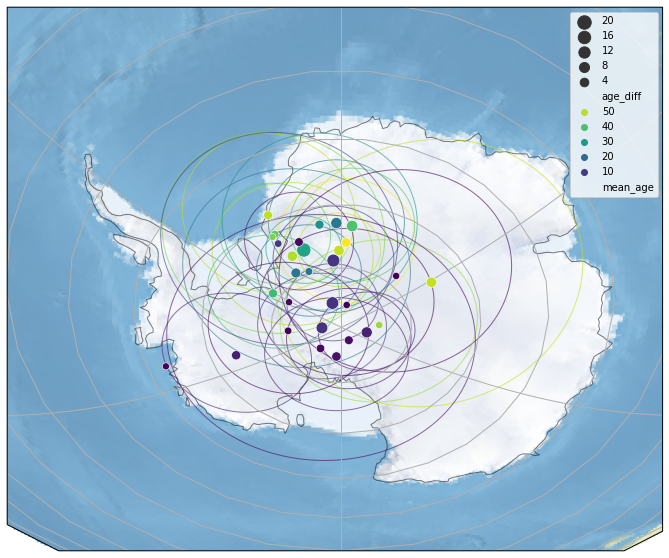

In [5]:
extent = (-180,180,-60,-90)
df_pole_compilation['age_diff'] = df_pole_compilation['max_age'] - df_pole_compilation['min_age']

plot_poles(df = df_pole_compilation, 
           plon = 'Plon', plat = 'Plat', A95 = 'A95',
           clr_scaling = 'mean_age', size_scaling = 'age_diff',
           extent = extent, plot_A95s = True, connect_poles=False)

    age     N  n_studies           k       A95       csd        plon  \
0   0.0  15.0       15.0  156.445419  3.066621  6.475952  295.238097   
1  10.0  15.0       15.0  156.445419  3.066621  6.475952  295.238097   
2  20.0   4.0        4.0  694.396487  3.489190  3.073840  344.010800   
3  30.0   6.0        6.0  587.913266  2.765648  3.340630  336.878569   
4  40.0   7.0        7.0  254.354466  3.792217  5.078849  335.700518   
5  50.0   9.0        9.0  194.731830  3.698646  5.804523  351.383438   
6  60.0   4.0        4.0  163.963607  7.196709  6.325739    3.003732   

        plat  
0 -87.078353  
1 -87.078353  
2 -81.836813  
3 -82.328426  
4 -82.789218  
5 -82.545240  
6 -82.175571  


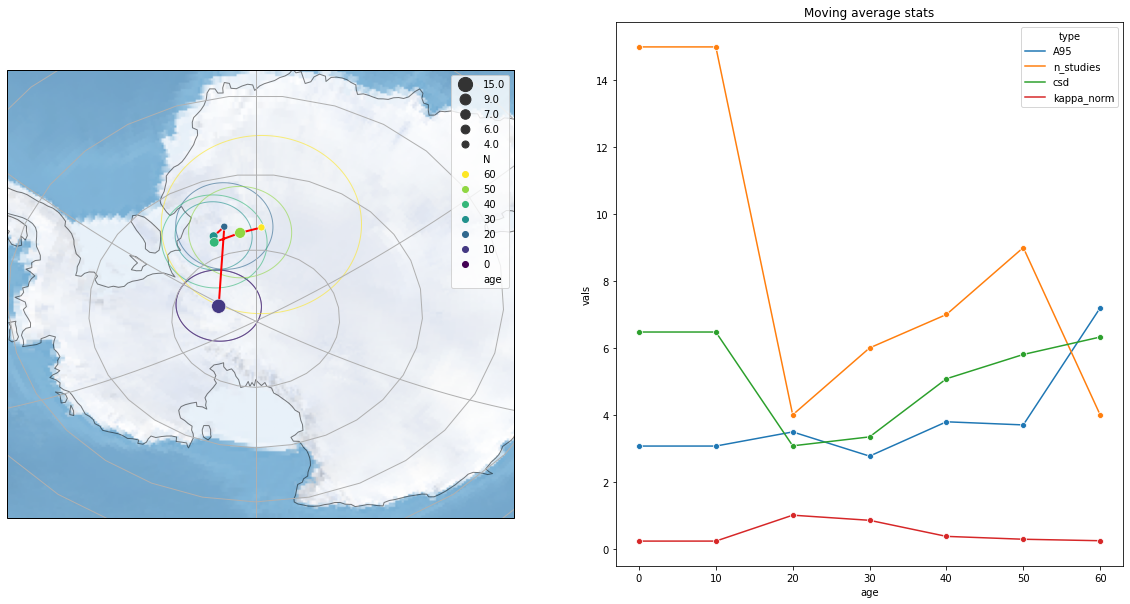

In [16]:
min_age = 0
max_age = 60
window_length = 20
time_step = 10

RM_APWP_rec_POLES = running_mean_APWP(df_pole_compilation, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
print(RM_APWP_rec_POLES)

extent = (-180,180,-70,-90)
plot_poles_and_stats(RM_APWP_rec_POLES, 'plon', 'plat', 'A95', 'age', 'N', extent, connect_poles=True)

In [6]:
def R_pole_space(ref_pole,ref_A95,obs_pole,obs_A95,local):
    """
    Compute rotation angle R with uncertainty dR using the pole-space approach of Ch.11 from Butler (1992)
    
    Required input:
    Observed pole -> [lon,lat]
    A95 of observed pole
    Reference pole -> [lon,lat]
    A95 of reference pole
    Sampling locality [lon,lat]

    Output:
    R, dR
    """

    p_r = pmag.angle(ref_pole,local) # compute angular distance p_r between reference pole and sampling locality
    p_o = pmag.angle(obs_pole,local) # compute angular distance p_o between observed pole and sampling locality
    s = pmag.angle(ref_pole,obs_pole) # compute angular distance s between observed pole and reference pole

    #print(p_r,p_o,s)

    # compute rotation angle R in degrees (eq. A72)
    R = np.rad2deg(np.arccos( (np.cos(np.deg2rad(s))-np.cos(np.deg2rad(p_o))*np.cos(np.deg2rad(p_r))) / (np.sin(np.deg2rad(p_o))*np.sin(np.deg2rad(p_r))) ))

    # compute dDx and dDo (eq. A74 and A75)
    delta_Dr = np.rad2deg (np.arcsin(np.sin(np.deg2rad(ref_A95))/np.sin(np.deg2rad(p_r))))
    delta_Do = np.rad2deg (np.arcsin(np.sin(np.deg2rad(obs_A95))/np.sin(np.deg2rad(p_o))))
    #print(delta_Do)

    # compute delta_R
    delta_R = 0.8*np.sqrt(delta_Dr**2+delta_Do**2)
    
    #print('R+dR = ',R[0],'+-',delta_R[0])

    return R[0], delta_R[0]

def P_pole_space(ref_pole,ref_A95,obs_pole,obs_A95,local):
    """
    Compute poleward transport P with uncertainty dP using the pole-space approach of Ch.11 from Butler (1992)
    
    Required input:
    Observed pole -> [lon,lat]
    A95 of observed pole
    Reference pole -> [lon,lat]
    A95 of reference pole
    Sampling locality [lon,lat]

    Output:
    P, dP
    """

    p_r = pmag.angle(ref_pole,local) # compute angular distance p_r between reference pole and sampling locality
    p_o = pmag.angle(obs_pole,local) # compute angular distance p_o between observed pole and sampling locality

    # compute rotation angle R in degrees (eq. A72)
    P = p_o - p_r

    # compute dDx and dDo (eq. A74 and A75)
    delta_p_r = ref_A95
    delta_p_o = obs_A95

    # compute delta_R
    delta_P = 0.8*np.sqrt(delta_p_r**2+delta_p_o**2)

    return P[0], delta_P


## Compute R and p 

In [36]:
min_age = 40
max_age = 60
N_poles = len(df_pole_compilation)

ref_pole = [RM_APWP_rec_POLES.loc[RM_APWP_rec_POLES.age == (min_age+max_age)/2,'plon'].values[0],RM_APWP_rec_POLES.loc[RM_APWP_rec_POLES.age == (min_age+max_age)/2,'plat'].values[0]]
ref_A95 = RM_APWP_rec_POLES.loc[RM_APWP_rec_POLES.age == (min_age+max_age)/2,'A95'].values[0]
print(ref_pole,ref_A95)

df_sel = df_pole_compilation[(df_pole_compilation.mean_age > min_age) & (df_pole_compilation.mean_age < max_age)]
#df_sel.head()

[351.38343807045203, -82.54524033096449] 3.698645660335166


In [37]:
for i in range(len(df_sel)):
    print(i,df_sel.iloc[i]['Study'])

    obs_pole = [df_sel.iloc[i]['Plon'],df_sel.iloc[i]['Plat']]
    obs_A95 = df_sel.iloc[i]['A95']
    print(obs_pole,obs_A95)
    
    locality = [df_sel.iloc[i]['slon'],df_sel.iloc[i]['slat']]
    
    # compute angular difference
    GCD = pmag.angle(obs_pole,ref_pole)
    print('Angle = ',GCD[0])

    # compute rotation in pole-space
    R,dr = R_pole_space(ref_pole,ref_A95,obs_pole,obs_A95,locality)
    print('Rotation: %1.1f +- %1.1f degrees' % (R,dr))
    if R-dr>0 or R+dr<0: # check if lower confidence limit of rotation is larger than zero
      print('=> statistically significant')
    else:
      print('=> not significant')

    # compute latitudinal displacement in pole-space
    plat_ref_pole = 90 - pmag.angle(ref_pole,locality)[0]
    print('Plat ref_pole = ',plat_ref_pole)
    plat_obs_pole = 90 - pmag.angle(obs_pole,locality)[0]
    print('Plat obs_pole = ',plat_obs_pole)

    P,dp = P_pole_space(ref_pole,ref_A95,obs_pole,obs_A95,locality)
    print('Paleolatitudinal displacement: %1.1f +- %1.1f degrees' % (P,dp))
    if P-dp>0 or P+dp<0: # check if lower confidence limit of rotation is larger than zero
      print('=> statistically significant')
    else:
      print('=> not significant')
    
    print('')

0 Absaroka_volcanics
[329.1327400012501, -81.80767029804308] 6.940482920540916
Angle =  3.0959882795515723
Rotation: 0.5 +- 8.7 degrees
=> not significant
Plat ref_pole =  -45.61827006295468
Plat obs_pole =  -42.54059873906115
Paleolatitudinal displacement: -3.1 +- 6.3 degrees
=> not significant

1 Beaver_River_intrusions
[327.6698411828201, -79.31324219108687] 4.79231159482962
Angle =  4.878000866377452
Rotation: 6.4 +- 9.9 degrees
=> not significant
Plat ref_pole =  -62.83909001044046
Plat obs_pole =  -59.07999282798821
Paleolatitudinal displacement: -3.8 +- 4.8 degrees
=> not significant

2 Bighorn_Basin_sediments
[2.7617375051177744, -81.54904237017679] 5.954671948866425
Angle =  1.8582694883539794
Rotation: 1.1 +- 8.2 degrees
=> not significant
Plat ref_pole =  -45.225992468530364
Plat obs_pole =  -46.91259355639596
Paleolatitudinal displacement: 1.7 +- 5.6 degrees
=> not significant

3 Bitterroot_Dome_intrusions
[61.19957874262291, -81.1990906455448] 13.418645523798173
Angle =  9